# Comparison of Adaptive Filters (LMS, NLMS, RLS, GNGD) - AR Model Identification in the Prediction Setting
Lets start with importing padasip and make some initial settings. In the following examples we will also use numpy, matplotlib for plotting and signalz for data generation.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pylab as plt

import signalz
import padasip as pa

%matplotlib inline 
plt.style.use('ggplot') # nicer plots
np.random.seed(52102) # always use the same random seed to make results comparable

## Used data

The used signal (target) $d(k)$ is white noise $v(k)$ with zero mean and unit variance, passed through an autoregressive model given by following equation

$d(k) = 1.79 d(k-1) - 1.85 d(k-2) + 1.27 d(k-3) - 0.41 d(k-4) + v(k)$

From equation above it is obvious that this process is stationary. According to this equation was generated data of length 3000 samples. The Python code and figures of data follow

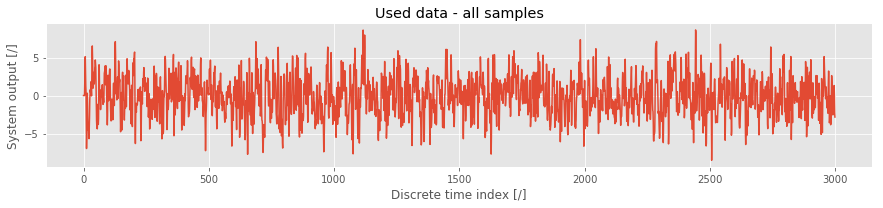

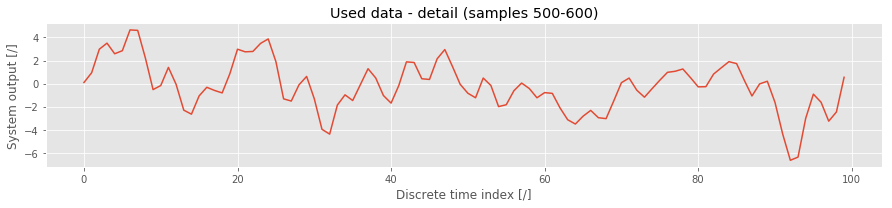

In [2]:
# AR model parameters
h = [-0.41, 1.27, -1.85, 1.79]

# pass white noise to AR model (3000 samples)
N = 3000
d = signalz.autoregressive_model(N, h, noise="white")

# plot data
plt.figure(figsize=(12.5,3))
plt.plot(d)
plt.title("Used data - all samples")
plt.xlabel("Discrete time index [/]")
plt.ylabel("System output [/]")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12.5,3))
plt.plot(d[500:600])
plt.title("Used data - detail (samples 500-600)")
plt.xlabel("Discrete time index [/]")
plt.ylabel("System output [/]")
plt.tight_layout(); plt.show()

Now the data must be formed into input matrix so the Padasip adaptive filters can accept it. The code follows.

In [3]:
# input matrix for filters (4 taps)
n = 4
x = pa.preprocess.input_from_history(d, n)[:-1]
d = d[n:]

## Selection of learning rate
Selection of correct learning rate (in theory denoted commonly as $\mu$, in code of this tutorial as `mu`) is crucial task. A filter will not converge with badly selected learning rate (and or other parameters of adaptive filters). Furthermore, improper analysis of optimal parameters for a filter can lead to selection of wrong type of adaptive filter for given task. This section displays, how selection of the learning rate influence the mean-squared error (MSE) of data prediction/identification with adaptive filter.

For sake of simplicity, all used filters are stored in list that contains the filter instance, range for learning rates, name of filter and positions for plotting. Python code follows

In [4]:
# list of all filters (with other values like names, and positions in figures)
filters = [
    {"name": "LMS", "mu_s": 0.001, "mu_e": 0.05, "filter": pa.filters.FilterLMS(n), "plot_position": 221 },
    {"name": "NLMS", "mu_s": 0.01, "mu_e": 2., "filter": pa.filters.FilterNLMS(n), "plot_position": 222 },
    {"name": "GNGD", "mu_s": 0.01, "mu_e": 4., "filter": pa.filters.FilterGNGD(n), "plot_position": 223 },
    {"name": "RLS", "mu_s": 0.001, "mu_e": 1., "filter": pa.filters.FilterRLS(n), "plot_position": 224 },    
]

The minimal and maximal learning rates tested (`mu_s`, `mu_e`) were selected according to the general recomendations and tuned experimentaly. For all of the filters was used the same testing setting

* 50% of samples for training, 50% of samples for MSE (mean squared error) measurement
* initial weights are set to zeros after every change of learning rate

The code and figures follow

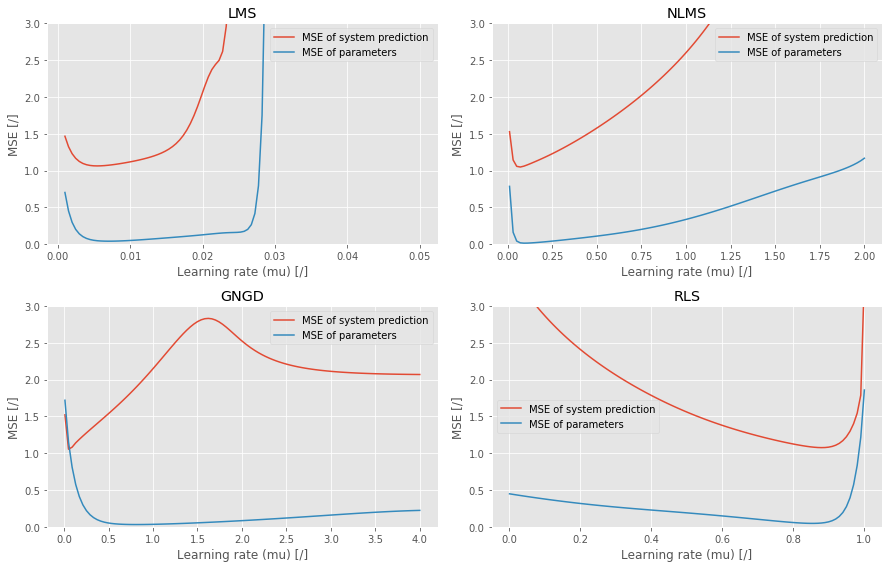

In [5]:
plt.figure(figsize=(12.5,8))

# iterate over all filters
for i in range(len(filters)):
    # make sure that initial weights are zeros
    filters[i]["filter"].init_weights("zeros")
    # get mean error for learning rates in given range
    errors_e, mu_range = filters[i]["filter"].explore_learning(d, x, mu_start=filters[i]["mu_s"],
                                        mu_end=filters[i]["mu_e"],
                                        steps=100, ntrain=0.5, epochs=1, criteria="MSE")
    # get deviation of weights from parameters of AR model
    errors_w, mu_range = filters[i]["filter"].explore_learning(d, x, mu_start=filters[i]["mu_s"],
                                        mu_end=filters[i]["mu_e"],
                                        steps=100, ntrain=0.5, epochs=1, criteria="MSE", target_w=h)
    
    # save the best learning rate for later use
    filters[i]["filter"].mu = mu_range[np.argmin(errors_w)]
    # plot it
    plt.subplot(filters[i]["plot_position"])
    plt.plot(mu_range, errors_e, label="MSE of system prediction")
    plt.plot(mu_range, errors_w, label="MSE of parameters")
    plt.title(filters[i]["name"]); plt.xlabel("Learning rate (mu) [/]")
    plt.ylabel("MSE [/]"); plt.ylim(0,3); plt.legend()

plt.tight_layout()
plt.show()

As it is possible to see in figure above, the general recomendations match the obtained results summarized in following list

* the LMS filter needs really small learning rate - no recomended size
* the NLMS filter works with learning rate in range 0-2 (as its stability condition says)
* the GNGD filter is slightly more robust against wrong selection of learning rate than NLMS if only deviation of parameters is evaluated
* the RLS filter works on range 0-1, but values close to 1 works the best

## Closer look to identification
In this section is displayed how to weights change from zeros to its final states. The used learning rates were selected according previous section - the learning rates with the lowest MSE of weights/model deviation.

Python code and figure with results follows

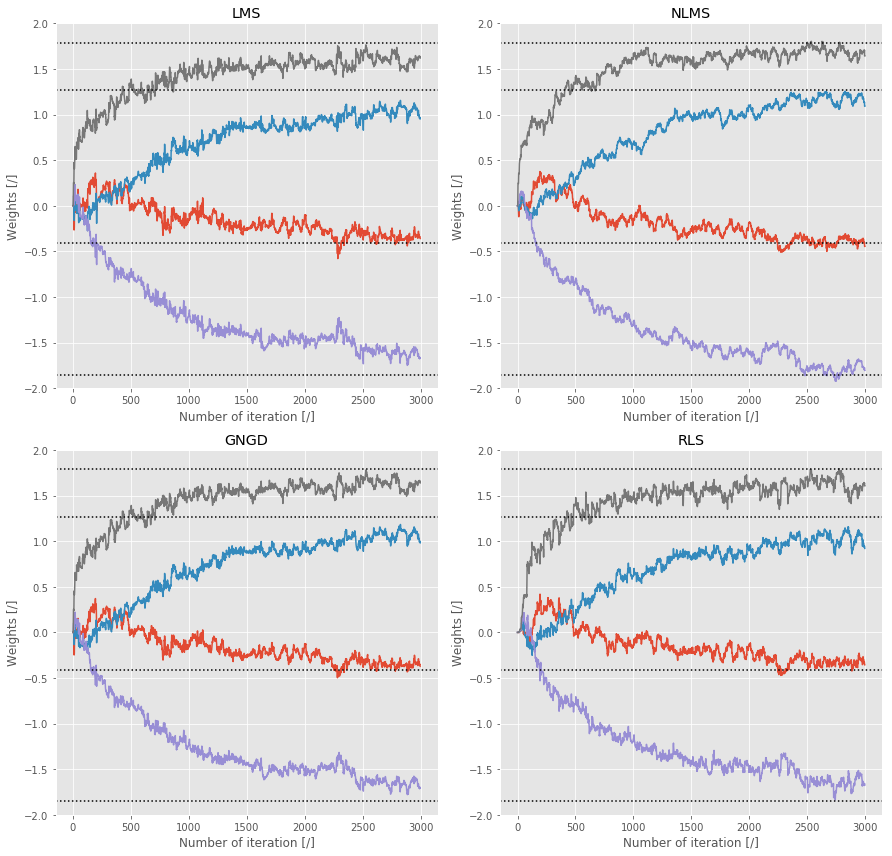

In [6]:
plt.figure(figsize=(12.5, 12))

# iterate over all filters
for i in range(len(filters)):
    # make sure that initial weights are zeros
    filters[i]["filter"].init_weights("zeros")
    # run the identification
    filters[i]["filter"].run(d, x)
    # get the history of weights
    w_history = filters[i]["filter"].w_history        
    # plot it
    plt.subplot(filters[i]["plot_position"])
    plt.plot(w_history)  
    plt.title(filters[i]["name"]); plt.xlabel("Number of iteration [/]")
    plt.ylabel("Weights [/]"); plt.ylim(-2,2)
    # draw lines representing system parameters
    for coef in h:
        plt.axhline(y=coef, color="black", linestyle=':')
    
plt.tight_layout(); plt.show()

The figure above displays how the weights are adapted in time to decrease the prediction error. The AR model parameters are shown by dotted black lines. As you can see, with optimal learning rate all filters produce visually similar result. There is no obvious big difference in final weights deviation nor speed of weights convergence. However, that is probably given by fact, that all of the learning rates were selected in order to produce the optimal result during testing on second half of data after training on first half of the data.

## Identification accuracy

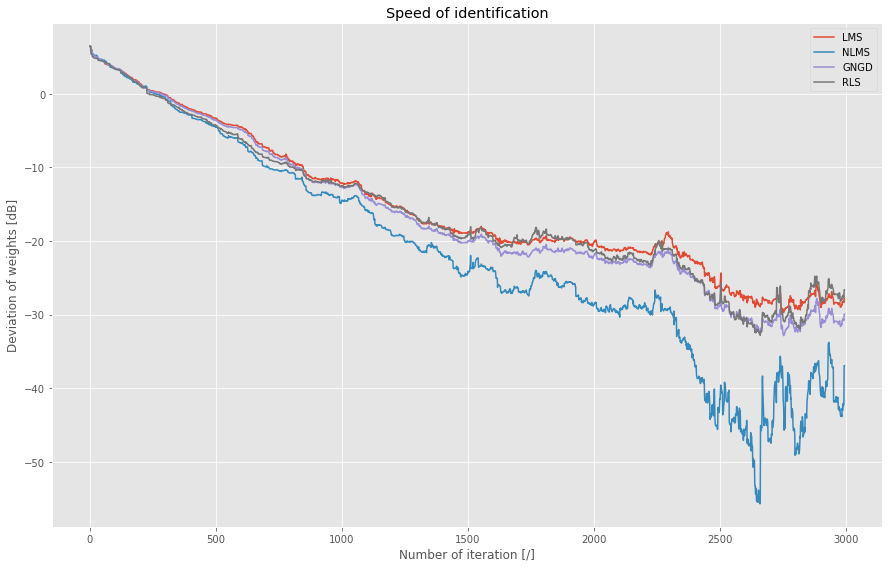

In [7]:
plt.figure(figsize=(12.5, 8))

# iterate over all filters
for i in range(len(filters)):
    # make sure that initial weights are zeros
    filters[i]["filter"].init_weights("zeros")
    # run the identification
    filters[i]["filter"].run(d, x)
    # get the history of weights
    w_history = filters[i]["filter"].w_history     
    deviation = pa.misc.logSE(np.mean((w_history - h)**2, axis=1))
    # plot it
    plt.plot(deviation, label=filters[i]["name"])  
    plt.title("Speed of identification"); plt.xlabel("Number of iteration [/]")
    plt.ylabel("Deviation of weights [dB]")
    
plt.tight_layout(); plt.legend(); plt.show()


## Conclusion

The results obtained in this tutorial can be sumarized in following points

* All of LMS, GNGD, RLS have really similar identification accuracy for given stationary system, if the learning rate is selected properly for given ammount of training.
* The NLMS filter seems to identify given system somehow better than other tested filters.
* Selection of the correct learning rate for LMS filter can be really tricky (because it is not defined any range where it should be).

Another important note is, that the learning rate of the LMS filter is not normalized according to the size of input (in sample after sample way), this fact can produce much bigger issues with nonstationary and offseted data.

According to this findings, the usage of the NLMS filter should be always prefered over the LMS filter. The RLS and GNGD filters can be beneficial in some cases, but probably not in cases like the one presented in this tutorial.